In [1]:
## importing the main packages and libraries
import pandas as pd
import numpy as np
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.types import Command
from langchain_core.tools import tool
from pydantic import BaseModel,Field,field_validator

In [2]:
import os
load_dotenv()
api_key = os.environ["OPENAI_API_KEY"]

In [3]:
## loading my llm into my system
llm = ChatOpenAI(model="gpt-4",api_key = api_key)

In [4]:
## testing my llm
llm.invoke("what is machine learning and Data Science").content ## my llm is working fine

'Machine Learning is a subset of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves. The process of learning begins with observations or data, such as examples, direct experience, or instruction, in order to look for patterns in data and make better decisions in the future.\n\nData Science is an interdisciplinary field that uses scientific methods, processes, algorithms, and systems to extract knowledge and insights from structured and unstructured data. It involves various fields such as statistics, machine learning, data analysis with the goal to derive insights from data in various forms. It also involves techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, and information science. Data scientists use their skills in both

In [5]:
## now first we will check either the date/time provided by the pateint is in correct format or not
## if the date/time is in correct format then we will proceed next 
## if not then we will throw the error saying that date/time provided by you is not in correct format ,put it in this particular format


In [6]:
import re
class DateTimeModel(BaseModel):
    date:str = Field(description="properly fomatted date",pattern = r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator("date")
    def date_validator(cls,value):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$',value):
            raise ValueError(f"Date must me in correct format 'DD-MM-YYYY HH:MM':{value}")
        else:
            return value

In [7]:
import re
class DateModel(BaseModel):
    date:str = Field(description="properly formatted date",pattern = r'^\d{2}-\d{2}-\d{4}$')
    @field_validator("date")
    def date_validator(cls,value):
        if not re.match(r'^\d{2}-\d{2}-\d{4}',value):
            raise ValueError(f"Date must be in correct format 'DD-MM-YYYY':{value}")
        else:
            return value

In [8]:
## class for checking either the unique number provided by the patient is correct or not
class UniqueIdentificationNumber(BaseModel):
    id:int = Field(description = "a unique number withe 7 or 8 digits")
    @field_validator("id")
    def id_validator(cls,value):
        if not re.match(r'^\d{7,8}$',str(value)):
            raise ValueError("The value must be of 7 or 8 digits")
        return value

In [9]:
## loading my data frame ,from where i will extract the information
import pandas as pd
df = pd.read_csv(r"D:\Doctor_Appointment_System\data\doctor_availability.csv")

In [10]:
## now we are going to define a function which will check the availibilty by doctor
from typing import Literal
@tool
def check_availibility_by_doctor(desired_date:DateModel,doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    "checking the availibilty of doctor based on date and doctor name"
    df["date_slot_time"] = df["date_slot"].apply(lambda x:x.split(' ')[-1])
    
    rows = list(df[(df["date_slot"].apply(lambda x:x.split(' ')[0])==desired_date.date)&(df["doctor_name"]==doctor_name)&(df["is_available"]==True)]["date_slot_time"])

    if len(rows) == 0:
        output = "No available slots"
    else:

        output = f""" for the given date {desired_date.date} and desired doctor {doctor_name} These are the available slots\n
                    {' '.join(rows)}
                    """
        return output
    


In [11]:
## creating a function which will extract information from the dataframe based on the desired date and specialization
@tool
def check_availibility_by_specialization(desired_date:DateModel,specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    "This tool will help to extract information from the dateframe on base of desired date and specialization"

    df["date_slot_time"] = df["date_slot"].apply(lambda x:x.split(" ")[1])

    rows = df[(df["date_slot"].apply(lambda x:x.split(" ")[0])==desired_date.date)&(df["specialization"]==specialization)&(df["is_available"]==True)].groupby(["specialization","doctor_name"])["date_slot_time"].apply(list).reset_index(name = "available_slots")

    if len(rows) == 0:
        output = "No available slots"
        return output
    def value_to_am_pm(value):
        ## value = 14:30 ,just example
        hours,minutes = map(int,value.split(":")) ## [14,30]
        if hours>=12:
            period = "PM"
        else:
            period = "AM"
        hours = hours%12 or hours
        return f"{hours}:{minutes:02d} {period}"
    output = ""
    for row in rows.values:
        value = f"The doctor {row[1]} is available at this slots {' '.join([value_to_am_pm(value) for value in row[2]])}\n\n"
        output = output+value
    return output
    
    

In [12]:
@tool
def cancel_appointment(date:DateTimeModel,id_number:UniqueIdentificationNumber,doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    "This function is just for cancelling the appointment of the doctor"
   
    rows = df[(df["date_slot"] == date.date)&(df["patient_to_attend"]==id_number.id)&(df["doctor_name"]==doctor_name)]
    if len(rows) == 0:
        output = "There are no available bookings"
        return output
    else:
        df.loc[(df["date_slot"]== date.date)&(df["patient_to_attend"]==id_number.id)&(df["doctor_name"]==doctor_name),["is_available","patient_to_attend"]] = [[True,None]]
        df.to_csv(r"D:\Doctor_Appointment_System\data\doctor_availability.csv",index=False)
        return "Successfully cancelled"

In [13]:
## now i will be writting the function for setting the appointment with the doctor
@tool
def set_appointment(desired_date:DateTimeModel,id_number:UniqueIdentificationNumber,doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    "tool for setting the appointment with the doctor"
    value = df[(df["date_slot"]==desired_date.date)&(df["is_available"]==True)&(df["doctor_name"]==doctor_name)]
    if len(value) ==0:
        return "There is no availibility of doctor at this time"
    else:
      df.loc[(df["date_slot"]==desired_date.date)&(df["is_available"]==True)&(df["doctor_name"]==doctor_name),["is_available","patient_to_attend"]] = [[False,id_number.id]]
      df.to_csv(r"D:\Doctor_Appointment_System\data\doctor_availability.csv",index=False)
      return "The appointment set successfully"
    

In [14]:
## now i will be writting the function for rescheduling the appointment
@tool
def reschedule_appointment(old_date:DateTimeModel,new_date:DateTimeModel,id_number:UniqueIdentificationNumber,doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    "tool for rescheduling the appointment with the doctor"
    rows = df[(df["date_slot"]==new_date.date)&(df["doctor_name"]==doctor_name)&(df["is_available"]==True)]
    if len(rows) ==0:
        return "there is no availibilty of doctors at this time"
    else:
        cancel_appointment.invoke({"date":old_date,"id_number":id_number,"doctor_name":doctor_name})
        set_appointment.invoke({"desired_date":new_date,"id_number":id_number,"doctor_name":doctor_name})
        return "Successfully rescheduled for the desired time"

In [56]:
type(reschedule_appointment)

langchain_core.tools.structured.StructuredTool

In [15]:
system_prompt = """
You are a supervisor agent. You will be provided a question. Based on the question, you need to determine whether it belongs to:
- Information fetching
- Booking/canceling/rescheduling

Return:
- "information" for info-related queries
- "booking" for booking/canceling/rescheduling
- "end" if it doesn’t fit either category

Only return one of these three words: information, booking, end.

Examples:
- "When is doctor John Doe available on 25-06-2024?" → information
- "I want to cancel my booking with doctor John Doe on 26-06-2024 20:00" → booking
- "I want to reschedule my booking to 27-06-2024 12:00" → booking
"""


class question_check(BaseModel):
    response:str = Field(description = "question belongs to information or booking or nothing")
prompt = ChatPromptTemplate.from_messages(
    [("system",system_prompt),
      ("human","{question}")]
)
question_checker = prompt | llm.with_structured_output(question_check)

d:\Doctor_Appointment_System\venv\lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [16]:
class AgentState(TypedDict):
    question:str ## this will be the question asked by the user
    user_id:int
    next:str ## based on the user question we will find know either this user question belongs to information_node or booking_node\
    information_respond:str ## it will tell to which category the information based question belongs to like by_doctor or by_specialization
    booking_respond:str ## it will tell you to which category the booking based question belongs to that is setting or cancelling or rescheduling
    data:str
    final_response:str

In [17]:
def Supervisor(State:AgentState):
    question = State.get("question",None)
    if question == None:
        raise Exception("The question not found in the supervisor")
    if question:
        respond = question_checker.invoke({"question":question}).response
    else:
        raise Exception("User question is not given")
    return {"question":question,"next":respond}


In [18]:
question="is doctor john doe available on 07-08-2025"
respond = question_checker.invoke({"question":question})
respond

question_check(response='information')

In [19]:
def router(state:AgentState):
    next = state.get("next",None)
    if next == None:
        raise Exception("next not found in router!")
    if next == "information":
        return "information"
    elif next == "booking":
        return "booking"
    else:
        return "end"
    

In [20]:
## till here we came to know that either the question belons to booking_node or information_node
## now inside information node we have two possibilites either information will be fetched out by availibility of doctor or by availability of specialist
## and inside booking node we have three possibilites either question will be about setting or cancelling or booking the appointment

In [21]:
## now i need to create different router if the question belogs to this sub category go to this or go to this
## or i can do a simple thing by introducing the react agent
## in react agent i will put both information_node sub category or booking_node three sub categories 

In [22]:
class information_node_class(BaseModel):
    response:str = Field(description="To which category the question belongs to 'by_doctor','by_specialization, 'end'")

In [23]:
def information_node(state:AgentState):
    question = state.get("question",None) ## now it is sure that this question belongs to information node
    ## since for information fetching i have two tools available,first tool belongs to check availibility by doctor
    ## and second tool belongs to check availibilty by specialization
    ## now i need to check this question belongs to which type of tool
    

    if question == None:
        raise Exception("question not found in information node")
    system_prompt = """ You are an intelligent and helpfull assistant.You will be provided  a question ,based on your knowledge you need to find out that 
    this question belongs to which category.There are two categories,in first category the question belongs to fetching information based on doctor and date.
    examples of first category questions are :

    on what slots doctor john deo  is available on 05-08-2025,
    is doctor john doe available on 06-08-2025

    if the question belongs to first category then return "by_doctor"

    in second category question will be based on specialist,
    for example:
    give me slots of general dentist available on 05-08-2025

    if the question belongs to second category then return "by_specialization"

    is there any prosthodontist available on 08-08-2024.

    if the question does not belong to any above category then return "end"

                       """

    prompt = ChatPromptTemplate.from_messages(
    [("system",system_prompt),
      ("human","{question}")]
     )

    information_checker = prompt | llm.with_structured_output(information_node_class)

    respond = information_checker.invoke({"question":question}).response

    return {"question":question,"information_respond":respond}

    

In [24]:
## after this i need to create the function which will be responsible for generating the responses based on by doctor
## this function will know that the particular question belongs to by_doctor(information_node)
## so i already have tool which can fetch the information based on doctor name and doctor date that is check_availibilty_by_doctor
## what i can do i can combine this tool with llm giving some prompt 

In [25]:
def router_information(state:AgentState):
    information_respond = state.get("information_respond",None)
    if information_respond == None:
        raise Exception("Information respond not found")
    if information_respond == "by_doctor":
        return "by_doctor"
    elif information_respond == "by_specialization":
        return "by_specialization"
    else:
        return "end"

In [26]:
class get_doctor_date(BaseModel):
    doctor_name:str = Field(description="doctor name")
    date:str = Field(descriptio= "date ")

In [27]:
from langchain_core.output_parsers import StrOutputParser
def information_node_by_doctor(state:AgentState):
    question = state.get("question",None)
    if question == None:
        raise Exception("the question not found in information node by doctor")
    ## from this question we need to fetch out the doctor name and date
    prompt = """You are a helpfull and intelligent system,you will be given a question such that you need to extract 
    doctor name and date from the question .
    for example:
     for this question "what are the available slots of doctor john doe available on 07-08-2025"
        here doctor name is john doe and date is 07-08-2025.you will give doctor_name and date as output"""
    
    system_prompt = ChatPromptTemplate.from_messages(
    [("system",prompt),
      ("human","{question}")]
     )
    fetcher = system_prompt | llm.with_structured_output(get_doctor_date)
    response = fetcher.invoke({"question":question})
    doctor_name = response.doctor_name
    date = response.date

    ## for the check_availibilty_by_doctor i have doctor name and date in string format
    ## i can put these both two values in this function and can retrieve the output
    ## that output along with question will be sent to llm,so here we will be following the basic principle of RAG system

    ## check_availibility_by_specialization.invoke({"desired_date": {"date":"03-09-2024"}, "specialization": "general_dentist"})
    output = check_availibility_by_doctor.invoke({"desired_date":{"date":date},"doctor_name":doctor_name})

    prompt_respond = """You are a very intelligent and helpful assistant. 
You will be provided with a question and the data retrieved based on the question. 
You need to generate a response based on both the question and the data. 
First, understand both clearly, and then generate a concise and informative response."""

    system_prompt_2 = ChatPromptTemplate.from_messages([
    ("system", prompt_respond),
    ("human", "Question: {question}\nData: {data}")
    ] )

    agent = system_prompt_2 | llm | StrOutputParser()
    final_response = agent.invoke({"question": question, "data": output})

    return {"data":output,"final_response": final_response}

    

In [28]:
rows = check_availibility_by_doctor.invoke({"desired_date":{"date":"05-08-2025"},"doctor_name":"john doe"})

In [29]:
type(rows)

NoneType

In [30]:
## same i will create the system for by_specailization
## and the user question will go to this system if supervisor finds that the information question belongs to by_specialization
class check_specialist_date(BaseModel):
    specialist:str = Field(description="The particular specialist")
    date:str  = Field(description="The Date where particular specialist is available")

def information_node_by_specialist(state:AgentState):
    question = state.get("question",None)
    if question == None:
        raise Exception("The question not found in information node by specialist")
    ## from this question we need to fetch out the doctor name and date
    prompt = """You are a helpfull and intelligent system,you will be given a question such that you need to extract 
    specialist and date from the question .
    for example:
     for this question "what are the available slots of general_dentist available on 07-08-2025"
        here specialist is general_dentist and date is 07-08-2025.you will give specialist and date as output"""
    
    system_prompt = ChatPromptTemplate.from_messages(
    [("system",prompt),
      ("human","{question}")]
     )
    fetcher = system_prompt | llm.with_structured_output(check_specialist_date)
    response = fetcher.invoke({"question":question})
    specialist = response.specialist
    date = response.date

    ## for the check_availibilty_by_doctor i have doctor name and date in string format
    ## i can put these both two values in this function and can retrieve the output
    ## that output along with question will be sent to llm,so here we will be following the basic principle of RAG system

    ## check_availibility_by_specialization.invoke({"desired_date": {"date":"03-09-2024"}, "specialization": "general_dentist"})
    output = check_availibility_by_specialization.invoke({"desired_date":{"date":date},'specialization':specialist})

    prompt_respond = """You are a very intelligent and helpful assistant. 
You will be provided with a question and the data retrieved based on the question. 
You need to generate a response based on both the question and the data. 
First, understand both clearly, and then generate a concise and informative response."""

    system_prompt_2 = ChatPromptTemplate.from_messages([
    ("system", prompt_respond),
    ("human", "Question: {question}\nData: {data}")
    ] )

    agent = system_prompt_2 | llm | StrOutputParser()
    final_response = agent.invoke({"question": question, "data": output})

    return {"data":output,"final_response": final_response}

In [31]:
## I am done with information part coding
## now i will move to booking part coding

In [32]:
class booking_node_class(BaseModel):
    response:str = Field(description="To which category the booking belongs to 'cancel_booking','set_booking', 'reschedule_booking','end' ")
    

In [33]:
def booking_node(state:AgentState):
    question = state.get("question",None) ## now it is sure that this question belongs to booking node
    if question == None:
        raise Exception("The question not found on booking node")

    system_prompt = """ You are an intelligent and helpfull assistant.You will be provided  a question ,based on your knowledge you need to find out that 
    this question belongs to which category.There are three categories,in first category the question belongs to set the booking with doctor.
    second category for cancelling the booking with the doctor
    third category belong to rescheduling the booking 

    examples of first category questions are :

    i want to set booking on 05-08-2025 13:00 with john doe , for this case return 'set_booking'



    in second category question will be based on cancelling the booking with the doctor,
    for example:
    I want to cancle the booking with doctor john doe on 05-08-2025 14:00

    if the question belongs to second category then return "cancel_booking"

   third category belongs to rescheduling the booking with the doctor,for example
   I want to reschedule booking with doctor on "24-5-2024 08:00" which was on "23-5-2025 08:00"

   for this case return  "reschedule_booking"

    if the question does not belong to any above category then return "end"

                       """

    prompt = ChatPromptTemplate.from_messages(
    [("system",system_prompt),
      ("human","{question}")]
     )

    information_checker = prompt | llm.with_structured_output(booking_node_class)

    respond = information_checker.invoke({"question":question}).response

    return {"question":question,"booking_respond":respond}

    

In [55]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000245A535C6A0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000245A57D32E0>, root_client=<openai.OpenAI object at 0x0000024592D58160>, root_async_client=<openai.AsyncOpenAI object at 0x00000245A535CEB0>, model_name='gpt-4', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [34]:
def router_booking(state:AgentState):
    booking_respond = state.get('booking_respond',None)
    if booking_respond == None:
        raise Exception("booking_respond not found in router booking")
    if booking_respond == "set_booking":
        return "set_booking"
    elif booking_respond == "cancel_booking":
        return "cancel_booking"
    elif booking_respond == "reschedule_booking":
        return "reschedule_booking"
    elif booking_respond == "end":
        return "end"
    

In [35]:
## now the question has been passed through the booking node and we know that either the question belongs to set ,cancel or rescheduling category
## so let us take the first case where the user question belonge to set the booking with doctor
## similarly we will also conider all other cases,first let us create the system for this case

In [36]:
class booking_cancel(BaseModel): ## from the question we will be fetching doctor_name and date ,id from the state dict
    doctor_name:str = Field(description="doctor name")
    date:str = Field(description= "date ")

In [ ]:
def booking_node_for_cancel(state:AgentState):
    question = state.get("question",None)
    if question == None:
        raise Exception("The question not found in booking_node_for_cancel")
    user_id = state.get("user_id",None)
    if user_id == None:
        raise Exception("The user_id not found in booking_node_for_cancel")
    
    ## from this question we need to fetch out the doctor name and date
    prompt = """You are a helpfull and intelligent system,you will be given a question such that you need to extract 
    doctor name and date from the question .
    for example:
     for this question "I want to cancle the booking with doctor john doe on 07-08-2025 12:00 "
        here doctor name is john doe and date is '07-08-2025 12:00'.you will give doctor_name and date as output"""
    
    system_prompt = ChatPromptTemplate.from_messages(
    [("system",prompt),
      ("human","{question}")]
     )
    fetcher = system_prompt | llm.with_structured_output(booking_cancel)
    response = fetcher.invoke({"question":question})
    doctor_name = response.doctor_name
    date = response.date

    ## for the check_availibilty_by_doctor i have doctor name and date in string format,id
    ## i can put these both two values in this function and can retrieve the output
    ## that output along with question will be sent to llm,so here we will be following the basic principle of RAG system

    ## check_availibility_by_specialization.invoke({"desired_date": {"date":"03-09-2024"}, "specialization": "general_dentist"})
 
    output = cancel_appointment.invoke({"date":{"date":date},"doctor_name":doctor_name,"id_number":{"id":int(user_id)}})

    prompt_respond = """You are a very intelligent and helpful assistant. 
You will be provided with a question and the data retrieved based on the question. 
You need to generate a response based on both the question and the data. 
First, understand both clearly, and then generate a concise and informative response."""

    system_prompt_2 = ChatPromptTemplate.from_messages([
    ("system", prompt_respond),
    ("human", "Question: {question}\nData: {data}")
    ] )

    agent = system_prompt_2 | llm | StrOutputParser()
    final_response = agent.invoke({"question": question, "data": output})

    return {"data":output,"final_response": final_response}


In [38]:
class booking_set(BaseModel): ## from the question we will be fetching doctor_name and date ,id from the state dict
    doctor_name:str = Field(description="doctor name")
    date:str = Field(description= "date ")

In [39]:
def booking_node_for_set(state:AgentState):
    question = state.get("question",None)
    if question == None:
        raise Exception("The question not found in booking_node_for_set")
    user_id = state.get("user_id",None)
    if user_id == None:
        raise Exception("The user_id not found in booking_node_for_set")
    
    
    ## from this question we need to fetch out the doctor name and date
    prompt = """You are a helpfull and intelligent system,you will be given a question such that you need to extract 
    doctor name and date from the question .
    for example:
     for this question "I want to set the booking with doctor john doe on 07-08-2025 13:00 "
        here doctor name is john doe and date is '07-08-2025 13:00'.you will give doctor_name and date as output"""
    
    system_prompt = ChatPromptTemplate.from_messages(
    [("system",prompt),
      ("human","{question}")]
     )
    fetcher = system_prompt | llm.with_structured_output(booking_cancel)
    response = fetcher.invoke({"question":question})
    doctor_name = response.doctor_name
    date = response.date

    ## for the check_availibilty_by_doctor i have doctor name and date in string format,id
    ## i can put these both two values in this function and can retrieve the output
    ## that output along with question will be sent to llm,so here we will be following the basic principle of RAG system

    ## check_availibility_by_specialization.invoke({"desired_date": {"date":"03-09-2024"}, "specialization": "general_dentist"})
 
    output = set_appointment.invoke({"desired_date":{"date":date},"doctor_name":doctor_name,"id_number":{"id":int(user_id)}})

    prompt_respond = """You are a very intelligent and helpful assistant. 
You will be provided with a question and the data retrieved based on the question. 
You need to generate a response based on both the question and the data. 
First, understand both clearly, and then generate a concise and informative response."""

    system_prompt_2 = ChatPromptTemplate.from_messages([
    ("system", prompt_respond),
    ("human", "Question: {question}\nData: {data}")
    ] )

    agent = system_prompt_2 | llm | StrOutputParser()
    final_response = agent.invoke({"question": question, "data": output})

    return {"data":output,"final_response": final_response}


In [40]:
## same for rescheduling the appointment with the doctor
class booking_reschedule(BaseModel): ## from the question we will be fetching doctor_name and date ,id from the state dict
    doctor_name:str = Field(description="doctor name")
    new_date:str = Field(description= " new date for appointment with the doctor")
    old_date:str = Field(description = "old date of appointment with the doctor")
    

In [49]:
def booking_node_for_reschedule(state:AgentState):
    question = state.get("question",None)
    if question == None:
        raise Exception("The question not found in booking_node_for_reschedule")
    user_id = state.get("user_id",None)
    if user_id == None:
        raise Exception("The user_id not found in booking_node_for_reschedule")
    
    
    ## from this question we need to fetch out the doctor name and date
    prompt = """You are a helpfull and intelligent system,you will be given a question such that you need to extract 
    doctor name and new date,old date  from the question .
    for example:
     for this question "I want to reschedule the booking with doctor john doe on '07-08-2025 12:00' which was on '06-08-2025 11:00' "
        here doctor name is john doe ,new_date is '07-08-2025 12:00' and old_date is '06-08-2025 11:00' .you will give doctor_name and date as output"""
    
    system_prompt = ChatPromptTemplate.from_messages(
    [("system",prompt),
      ("human","{question}")]
     )
    fetcher = system_prompt | llm.with_structured_output(booking_reschedule)
    response = fetcher.invoke({"question":question})
    doctor_name = response.doctor_name
    old_date = response.old_date
    new_date = response.new_date

    ## for the check_availibilty_by_doctor i have doctor name and date in string format,id
    ## i can put these both two values in this function and can retrieve the output
    ## that output along with question will be sent to llm,so here we will be following the basic principle of RAG system

    ## check_availibility_by_specialization.invoke({"desired_date": {"date":"03-09-2024"}, "specialization": "general_dentist"})
 
    output = reschedule_appointment.invoke({"old_date":{"date":old_date},"new_date":{"date":new_date},"doctor_name":doctor_name,"id_number":{"id":int(user_id)}})

    prompt_respond = """You are a very intelligent and helpful assistant. 
You will be provided with a question and the data retrieved based on the question. 
You need to generate a response based on both the question and the data. 
First, understand both clearly, and then generate a concise and informative response."""

    system_prompt_2 = ChatPromptTemplate.from_messages([
    ("system", prompt_respond),
    ("human", "Question: {question}\nData: {data}")
    ] )

    agent = system_prompt_2 | llm | StrOutputParser()
    final_response = agent.invoke({"question": question, "data": output})

    return {"data":output,"final_response": final_response}

In [42]:
## now i will be creating the graph
from langgraph.graph import StateGraph,START,END
from typing import List
from typing_extensions import TypedDict

In [50]:
workflow = StateGraph(AgentState)
workflow.add_node("Supervisor",Supervisor)
workflow.add_node("information_node",information_node)
workflow.add_node("booking_node",booking_node)
workflow.add_node("information_node_by_doctor",information_node_by_doctor)
workflow.add_node("information_node_by_specialist",information_node_by_specialist)
workflow.add_node("booking_node_for_cancel",booking_node_for_cancel)
workflow.add_node("booking_node_for_set",booking_node_for_set)
workflow.add_node("booking_node_for_reschedule",booking_node_for_reschedule)

workflow.add_edge(START,"Supervisor")
workflow.add_conditional_edges("Supervisor",router,{"information":"information_node","booking":"booking_node","end":END})
workflow.add_conditional_edges("information_node",router_information,{"by_doctor":"information_node_by_doctor","by_specialization":"information_node_by_specialist","end":END})
workflow.add_edge("information_node_by_doctor",END)
workflow.add_edge("information_node_by_specialist",END)
workflow.add_conditional_edges("booking_node",router_booking,{"set_booking":"booking_node_for_set",
"cancel_booking":"booking_node_for_cancel","reschedule_booking":"booking_node_for_reschedule","end":END})

workflow.add_edge("booking_node_for_cancel",END)
workflow.add_edge("booking_node_for_set",END)
workflow.add_edge("booking_node_for_reschedule",END)

In [51]:
app = workflow.compile()

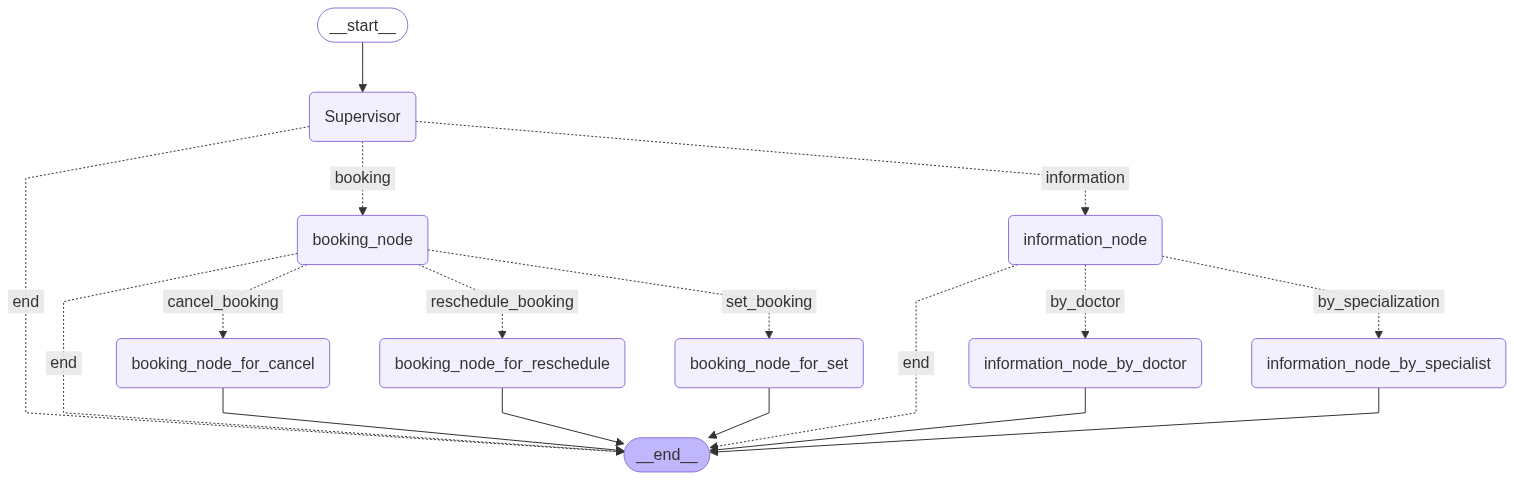

In [45]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
question = "I want to cancel session with doctor john doe on 08-08-2024 15:00 "
inputs = {"question":question,"user_id":1000097.0}
app.invoke(inputs)["final_response"]


d:\Doctor_Appointment_System\venv\lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(
d:\Doctor_Appointment_System\venv\lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


"Based on the data provided, you don't currently have any bookings with Dr. John Doe on 08-08-2024 at 15:00. Therefore, there is no need to cancel any appointments. Please check the date and time of your booking to ensure its accuracy."

In [52]:
question = "I want to reschedule  session with doctor john doe on  08-08-2024 10:00 which was held on 08-08-2024 10:30"
inputs = {"question":question,"user_id":1000030.0}
app.invoke(inputs)

d:\Doctor_Appointment_System\venv\lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(
d:\Doctor_Appointment_System\venv\lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'question': 'I want to reschedule  session with doctor john doe on  08-08-2024 10:00 which was held on 08-08-2024 10:30',
 'user_id': 1000030.0,
 'next': 'booking',
 'booking_respond': 'reschedule_booking',
 'data': 'Successfully rescheduled for the desired time',
 'final_response': 'Your session with Doctor John Doe has been successfully rescheduled from 10:30 AM to 10:00 AM on 08-08-2024.'}